# Parameter Estimation Workflow for conversion reaction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from scipy.stats import norm
from scipy.integrate import solve_ivp, dblquad

from bayesflow.networks import InvertibleNetwork, FlattenNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.diagnostics import *
from bayesflow.models import GenerativeModel

In [2]:
%load_ext autoreload
%autoreload 2

## Simulator settings

In [3]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------
    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) 
    """    
    # Prior range for log-parameters: k_1, k_2 ~ N(-0.75, 0.25²) iid.
    p_samples = np.random.normal(-0.75, 0.25, size=(batch_size, 2))
    return p_samples.astype(np.float32)


# ODE model for conversion reaction    
def conversion_reaction(t, x, theta):
    theta = 10**theta
    return np.array([-theta[0]*x[0]+theta[1]*x[1], theta[0]*x[0]-theta[1]*x[1]])

x0 = [1,0]   # initial condition       
sigma = 0.015   # noise standard deviation
n_obs = 11
time_points = np.linspace(0, 10, n_obs)


def batch_simulator(prior_samples, n_obs):   # n_obs (number of observations in each dataset)
    """
    Simulate multiple conversion model datasets via analytical solution of ODE
    """       
    n_sim = prior_samples.shape[0]   # batch size    
    sim_data = np.empty((n_sim, n_obs, 1), dtype=np.float32)   # 1 batch consisting of n_sim datasets, each with n_obs observations   
    
    for m in range(n_sim):
        theta = 10**prior_samples[m]
        s = theta[0] + theta[1]
        b = theta[0]/s
        state_2 = lambda t: b - b * np.exp(-s*t)
        sol = state_2(time_points)
        sim_data[m, :, 0] = sol + np.random.normal(0, sigma, size = n_obs)   # observable: y = x_2 + N(0,sigma²)
        
    return sim_data   

We build an amortized parameter estimation network.

In [4]:
bf_meta = {
    'n_coupling_layers': 4,
    's_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': 2
}

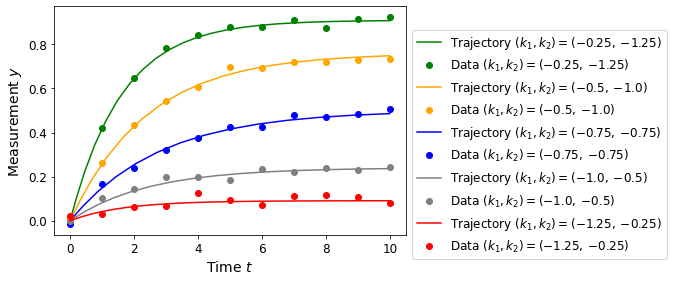

In [81]:
# Plot trajectories using different parameters from the prior
fig = plt.figure(figsize=(6.3, 4.2))
plt.rcParams['font.size'] = 12

rhs = lambda t,x: conversion_reaction(t, x, np.array([-0.25, -1.25]))
sol = solve_ivp(rhs, t_span = (0,10), y0 = x0, atol = 1e-9, rtol = 1e-6)
plt.plot(sol.t, sol.y[1], color='green', label='Trajectory $(k_1,k_2)=(-0.25, -\!1.25)$')    
sol = solve_ivp(rhs, t_span = (0,10), t_eval = time_points, y0 = x0, atol = 1e-9, rtol = 1e-6)
plt.plot(time_points, sol.y[1]+ np.random.normal(0, sigma, size = n_obs), 'o', color='green', label='Data $(k_1,k_2)=(-0.25, -\!1.25)$')

rhs = lambda t,x: conversion_reaction(t, x, np.array([-0.5, -1.0]))
sol = solve_ivp(rhs, t_span = (0,10), y0 = x0, atol = 1e-9, rtol = 1e-6)
plt.plot(sol.t, sol.y[1], color='orange', label='Trajectory $(k_1,k_2)=(-0.5, -\!1.0)$')    
sol = solve_ivp(rhs, t_span = (0,10), t_eval = time_points, y0 = x0, atol = 1e-9, rtol = 1e-6)
plt.plot(time_points, sol.y[1]+ np.random.normal(0, sigma, size = n_obs), 'o', color='orange', label='Data $(k_1,k_2)=(-0.5, -\!1.0)$')

rhs = lambda t,x: conversion_reaction(t, x, np.array([-0.75, -0.75]))
sol = solve_ivp(rhs, t_span = (0,10), y0 = x0, atol = 1e-9, rtol = 1e-6)
plt.plot(sol.t, sol.y[1], color='blue', label='Trajectory $(k_1,k_2)=(-0.75, -\!0.75)$') 
sol = solve_ivp(rhs, t_span = (0,10), t_eval = time_points, y0 = x0, atol = 1e-9, rtol = 1e-6)
plt.plot(time_points, sol.y[1]+ np.random.normal(0, sigma, size = n_obs), 'o', color='blue', label='Data $(k_1,k_2)=(-0.75, -\!0.75)$')

rhs = lambda t,x: conversion_reaction(t, x, np.array([-1.0, -0.5]))
sol = solve_ivp(rhs, t_span = (0,10), y0 = x0, atol = 1e-9, rtol = 1e-6)
plt.plot(sol.t, sol.y[1], color='grey', label='Trajectory $(k_1,k_2)=(-1.0, -\!0.5)$')    
sol = solve_ivp(rhs, t_span = (0,10), t_eval = time_points, y0 = x0, atol = 1e-9, rtol = 1e-6)
plt.plot(time_points, sol.y[1]+ np.random.normal(0, sigma, size = n_obs), 'o', color='grey', label='Data $(k_1,k_2)=(-1.0, -\!0.5)$')

rhs = lambda t,x: conversion_reaction(t, x, np.array([-1.25, -0.25]))
sol = solve_ivp(rhs, t_span = (0,10), y0 = x0, atol = 1e-9, rtol = 1e-6)
plt.plot(sol.t, sol.y[1], color='red', label='Trajectory $(k_1,k_2)=(-1.25, -\!0.25)$')    
sol = solve_ivp(rhs, t_span = (0,10), t_eval = time_points, y0 = x0, atol = 1e-9, rtol = 1e-6)
plt.plot(time_points, sol.y[1]+ np.random.normal(0, sigma, size = n_obs), 'o', color='red', label='Data $(k_1,k_2)=(-1.25, -\!0.25)$')

plt.xlabel('Time $t$', fontsize=14)
plt.ylabel('Measurement $y$', fontsize=14)
plt.legend(fontsize=12, bbox_to_anchor=(1,0.925))
plt.show()
fig.savefig("figures/{}_dynamics_new.png".format('CR11'), dpi=600, bbox_inches='tight')

## Computational faithfulness

In [5]:
# Demo dataset
param_prior = np.array([[-0.8316515  -0.41682813]]).astype(np.float32)
x_data = np.empty((1, n_obs, 1), dtype=np.float32)
x_data[0,:,0] = np.array([-0.00998038, 0.11607493, 0.16964884, 0.21061875, 0.22971621, 0.24310726, 0.26587075, 0.2802494, 0.26267728,  
                          0.29520127, 0.2685218 ])
n_post_samples = 7500

In [6]:
def prior_eval(x,y):   
    # Evaluates prior probability p(theta) according to k_1, k_2 ~ N(-0.75, 0.25²) iid.
    return norm.pdf(x,-0.75,0.25) * norm.pdf(y,-0.75,0.25)

def likelihood(x,y):   
    # Calculates likelihood p(x_{1:N} | theta)
    x = 10**x
    y = 10**y
    s = x + y
    b = x/s
    state_2 = lambda t: b - b * np.exp(-s*t)
    sol = state_2(time_points)
    residual = (x_data[0,:,0] - sol)/sigma
    nllh = np.sum(np.log(2*np.pi*sigma**2)+residual**2)/2
    return np.exp(-nllh)

def unnormalized_posterior(x,y):   
    # Evaluates the unnormalized posterior probability p(theta | x_{1:N}) according to Bayes' formula
    return likelihood(x,y) * prior_eval(x,y)

# scaling factor
scaling_factor = dblquad(unnormalized_posterior, -2.25, 0.75, lambda y: -2.25, lambda y: 0.75)
print(scaling_factor)
# normalized posterior
posterior_xy = lambda x,y: unnormalized_posterior(x,y)/scaling_factor[0]

(1945070712926.7678, 141864.35544586182)


TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./CR11_4ACB_[64,64,64]_ckpts\ckpt-300
TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./CR11_4ACB_[64,64,64]_LSTM(4)_ckpts\ckpt-300
TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./CR11_4ACB_[64,64,64]_LSTM(8)_ckpts\ckpt-300
TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./CR11_4ACB_[64,64,64]_LSTM(16)_ckpts\ckpt-300


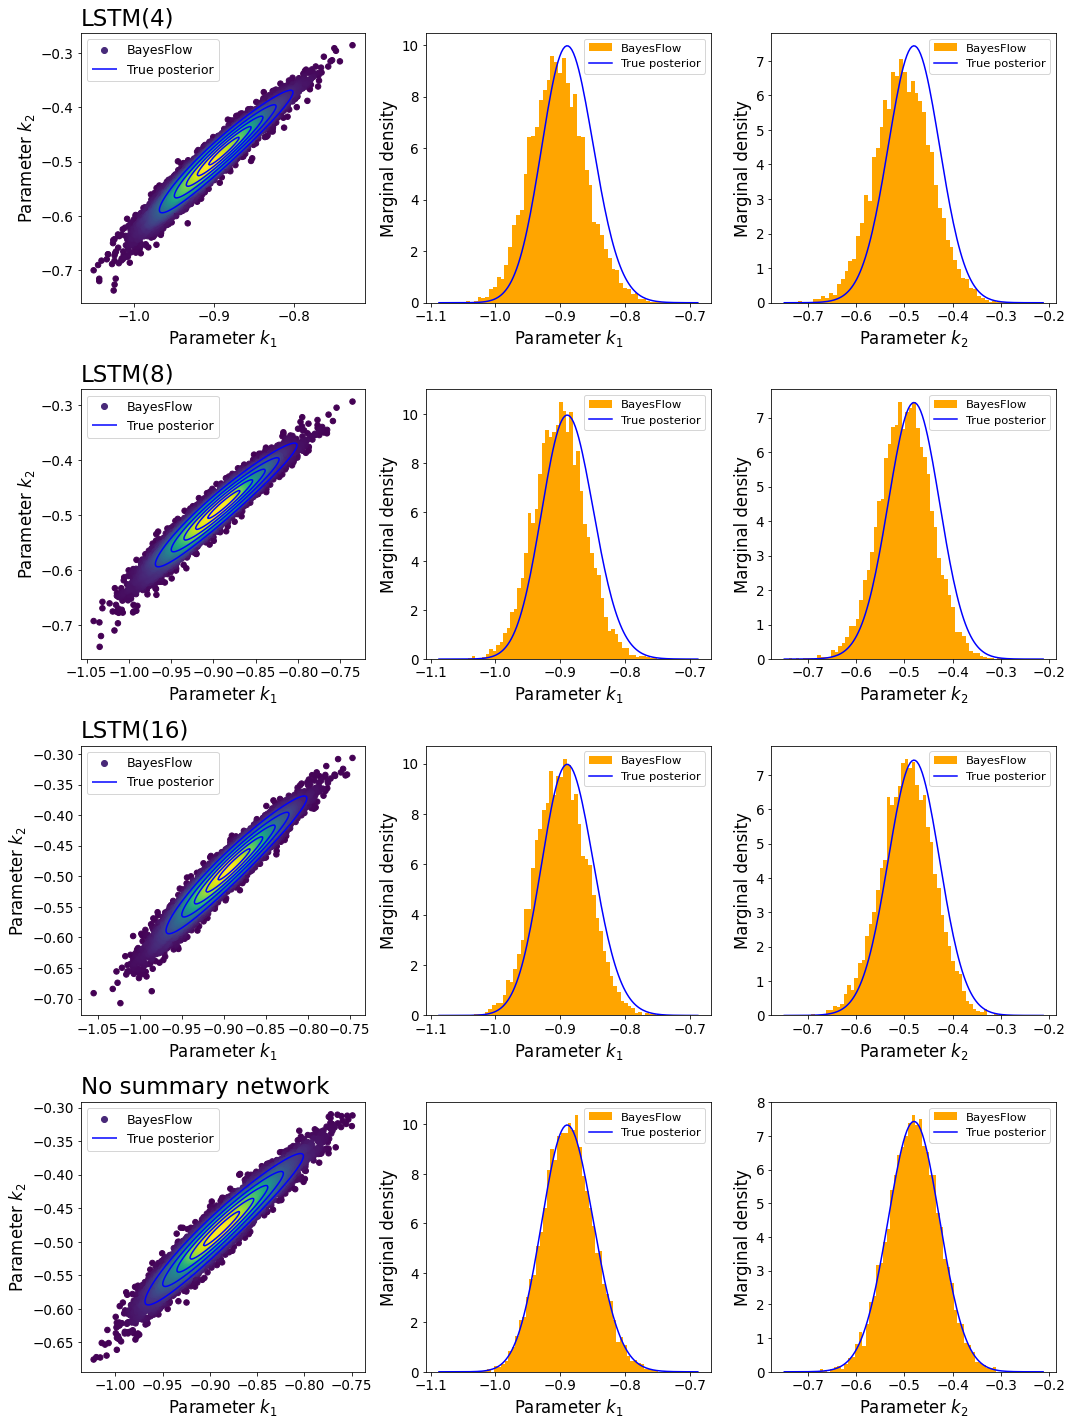

In [9]:
fig = plt.figure(figsize=(15, 20))
plt.rcParams['font.size'] = 13.5

# Load trained network (without LSTM)
summary_net = FlattenNetwork()
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
trainer = ParameterEstimationTrainer(network=amortizer, checkpoint_path = './CR11_4ACB_[64,64,64]_ckpts', skip_checks=True) 
# BayesFlow samples from the learned posterior
param_samples = amortizer.sample(x_data, n_post_samples)
mean_sample = np.mean(param_samples, axis=0)
cov_sample = np.cov(param_samples.transpose())
mean_x = mean_sample[0]
mean_y = mean_sample[1]
std_x = np.sqrt(cov_sample[0, 0])
std_y = np.sqrt(cov_sample[1, 1])

# Level sets of analytic posterior distribution
grid = 201
A = np.linspace(mean_x - 3 * std_x, mean_x + 3 * std_x, grid)
B = np.linspace(mean_y - 3 * std_y, mean_y + 3 * std_y, grid)
true_posterior = np.zeros((grid, grid))
for iy in range(0, grid):
    for ix in range(0, grid):
        true_posterior[iy][ix] = posterior_xy(A[ix], B[iy])
        
# Check marginal densities
grid = 151
C = np.linspace(mean_x - 5 * std_x, mean_x + 5 * std_x, grid)
D = np.linspace(mean_y - 5 * std_y, mean_y + 5 * std_y, grid)
bounds = np.array([mean_x - 8 * std_x, mean_x + 8 * std_x, mean_y - 8 * std_y, mean_y + 8 * std_y])
marginal_x = np.zeros(grid)
for i in range(grid):
    x = C[i]
    integrand_y = lambda y: posterior_xy(x, y)
    marginal_x[i] = quad(integrand_y, bounds[2], bounds[3])[0]
marginal_y = np.zeros(grid)
for j in range(grid):
    y = D[j]
    integrand_x = lambda x: posterior_xy(x, y)
    marginal_y[j] = quad(integrand_x, bounds[0], bounds[1])[0] 

plot_posterior_comparison(param_samples, A, B, C, D, true_posterior, marginal_x, marginal_y, 4, 'No summary network')

units = np.array([4, 8, 16])
n = 0
# Load trained networks (with LSTM)
summary_net = LSTM(units[n])
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
trainer = ParameterEstimationTrainer(network=amortizer, checkpoint_path = './CR11_4ACB_[64,64,64]_LSTM({})_ckpts'.format(units[n]), 
                                     skip_checks=True)
# BayesFlow samples from the learned posterior
param_samples_0 = amortizer.sample(x_data, n_post_samples)
plot_posterior_comparison(param_samples_0, A, B, C, D, true_posterior, marginal_x, marginal_y, n+1, 'LSTM({})'.format(units[n]))

n = 1
# Load trained networks (with LSTM)
summary_net = LSTM(units[n])
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
trainer = ParameterEstimationTrainer(network=amortizer, checkpoint_path = './CR11_4ACB_[64,64,64]_LSTM({})_ckpts'.format(units[n]), 
                                     skip_checks=True)
# BayesFlow samples from the learned posterior
param_samples_1 = amortizer.sample(x_data, n_post_samples) 
plot_posterior_comparison(param_samples_1, A, B, C, D, true_posterior, marginal_x, marginal_y, n+1, 'LSTM({})'.format(units[n]))

n = 2
# Load trained networks (with LSTM)
summary_net = LSTM(units[n])
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
trainer = ParameterEstimationTrainer(network=amortizer, checkpoint_path = './CR11_4ACB_[64,64,64]_LSTM({})_ckpts'.format(units[n]), 
                                     skip_checks=True)
# BayesFlow samples from the learned posterior
param_samples_2 = amortizer.sample(x_data, n_post_samples) 
plot_posterior_comparison(param_samples_2, A, B, C, D, true_posterior, marginal_x, marginal_y, n+1, 'LSTM({})'.format(units[n]))
    
plt.tight_layout()
plt.show()
fig.savefig("figures/{}_posterior_comparison.png".format('CR11'), dpi=300, bbox_inches='tight')   

Posterior predictive check: similarly good!

SBC plot: similarly good => no systematic bias